In [69]:
training_times={}
test_accuracies={}
test_losses={}

In [70]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_addons as tfa

In [113]:
TRAIL_NO = 4

#### Train-Val-Splits

In [72]:
#for train-val-test splits(run as cmd)
# !pip install split-folders
# !splitfolders --output ".\splits" --seed 123 --ratio 0.7 0.2 0.1 -- ".\caltech101_classification"

#### Buil Dataset Pipelines

In [131]:
#data pipeline
HEIGHT,WIDTH = 128,128
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False,
)

train_ds = datagen.flow_from_directory(
    './splits/train',
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
)

val_ds = datagen.flow_from_directory(
    './splits/val',
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
)

Found 1162 images belonging to 3 classes.
Found 331 images belonging to 3 classes.


In [132]:
label_map=val_ds.class_indices
print(label_map)

{'Motorbikes': 0, 'airplanes': 1, 'schooner': 2}


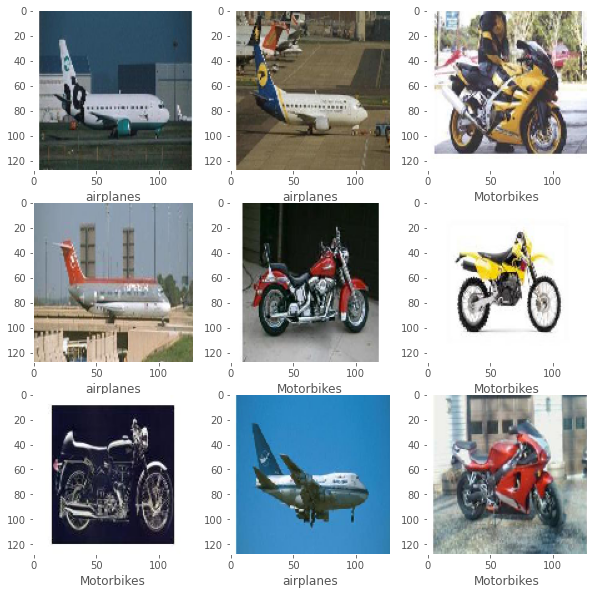

In [133]:
#visualize data
import random
random_list = random.sample(range(0, len(train_ds)), 10)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(False)
    plt.imshow(train_ds[random_list[i]][0][0])
    #show label using label_map
    plt.xlabel(list(label_map.keys())[list(label_map.values()).index(np.argmax(train_ds[random_list[i]][1][0]))])
plt.show()
    

#### Create Model and Train

In [117]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,3,activation='relu',input_shape=(HEIGHT,WIDTH,3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64,3,activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128,3,activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256,3,activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3,activation='sigmoid'),
    ])
    return model

In [118]:
from pathlib import Path
Path.mkdir(Path("./outputs/Trail {}".format(TRAIL_NO),"model"),parents=True,exist_ok=True)
Path.mkdir(Path("./outputs/Trail {}".format(TRAIL_NO),"plots"),parents=True,exist_ok=True)

In [120]:
metric = "val_categorical_accuracy"
def create_callbacks(metric = metric):
    base_path=Path('./outputs/Trail {}'.format(TRAIL_NO),'model')
    cpk_path = Path(base_path,'best_model.h5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= metric,
        mode='auto',
        save_best_only=True,
        verbose=1,
    )
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='auto',
        patience=4, 
        verbose=1
    )
    callbacks=[checkpoint,earlystop]   
    return callbacks

In [121]:
def compile_model(model, lr):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.CategoricalCrossentropy()
    f1_score=tfa.metrics.F1Score(num_classes=3, threshold=0.5)
    model.compile(optimizer=optimizer, loss=loss,metrics=[tf.keras.metrics.CategoricalAccuracy(),f1_score])
    return model

In [122]:
tf.keras.backend.clear_session()
#calculate time
import datetime
start_time = datetime.datetime.now()
with tf.device('/device:GPU:0'):
    model=create_model()
    model = compile_model(model, lr=0.001)
    callbacks = create_callbacks() 
    history = model.fit(train_ds,
                        epochs=15,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=1,
                       )
end_time = datetime.datetime.now()
training_times['Trail {}'.format(TRAIL_NO)] = end_time - start_time

Epoch 1/15
37/37 [==============================] - ETA: 0s - loss: 0.7392 - categorical_accuracy: 0.6730 - f1_score: 0.4623
Epoch 1: val_categorical_accuracy improved from -inf to 0.88218, saving model to outputs\Trail 4\model\best_model.h5
37/37 [==============================] - 7s 163ms/step - loss: 0.7392 - categorical_accuracy: 0.6730 - f1_score: 0.4623 - val_loss: 0.4375 - val_categorical_accuracy: 0.8822 - val_f1_score: 0.5668
Epoch 2/15
36/37 [============================>.] - ETA: 0s - loss: 0.3480 - categorical_accuracy: 0.8802 - f1_score: 0.6171
Epoch 2: val_categorical_accuracy improved from 0.88218 to 0.89728, saving model to outputs\Trail 4\model\best_model.h5
37/37 [==============================] - 6s 153ms/step - loss: 0.3486 - categorical_accuracy: 0.8804 - f1_score: 0.6174 - val_loss: 0.3282 - val_categorical_accuracy: 0.8973 - val_f1_score: 0.6463
Epoch 3/15
37/37 [==============================] - ETA: 0s - loss: 0.2627 - categorical_accuracy: 0.9139 - f1_score: 0

In [123]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

#### Test and Generate Plots

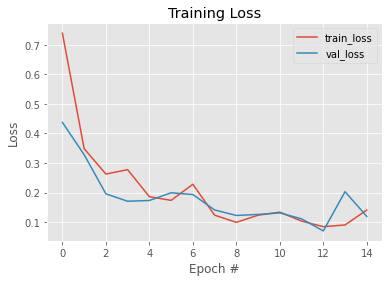

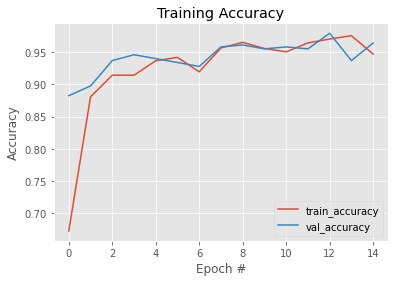

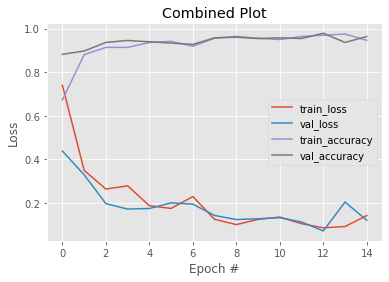

In [124]:
import matplotlib.pyplot as plt
from pathlib import Path
base_path=Path(f"./outputs/Trail {TRAIL_NO}","plots")
plotPaths=["loss_plot.png","accuracy plot.png","f1_score.png","lr_curve_plot.png","combined_plot.png"]
# construct a plot that plots and saves the training history
plt.style.use("ggplot")
#Loss Plot
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.savefig(Path(base_path,plotPaths[0]),dpi=300)
#Accuracy Plot
plt.figure()
plt.plot(history.history["categorical_accuracy"], label="train_accuracy")
plt.plot(history.history["val_categorical_accuracy"], label="val_accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.savefig(Path(base_path,plotPaths[1]),dpi=300)

# #F1-Score Plot
# plt.figure()
# plt.plot(history.history["f1_score"], label="f1_score")
# plt.plot(history.history["val_f1_score"], label="val_f1_score")
# plt.title("Training F1 Score")
# plt.xlabel("Epoch #")
# plt.ylabel("F1 Score")
# plt.legend(loc="best")
# plt.savefig(Path(base_path,plotPaths[2]),dpi=300)

#Learning Rate Plot
# plt.figure()
# plt.plot(history.history["lr"], label="Learning rate")
# plt.title("Learning Rate")
# plt.xlabel("Epoch #")
# plt.ylabel("lr")
# plt.legend(loc="best")
# plt.savefig(Path(base_path,plotPaths[3]),dpi=300)

#All-in-one Plot
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["categorical_accuracy"], label="train_accuracy")
plt.plot(history.history["val_categorical_accuracy"], label="val_accuracy")
# plt.plot(history.history["lr"], label="Learning rate")
plt.title("Combined Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.savefig(Path(base_path,plotPaths[4]),dpi=300)

In [125]:
#test dataset
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
test_ds = test_datagen.flow_from_directory(
            'splits/test/',
            target_size = (HEIGHT,WIDTH),
            class_mode='categorical',
            batch_size = 1,
            shuffle=False,
        )
test_ds.reset()
model_path=Path(f"./outputs/Trail {TRAIL_NO}","model","best_model.h5")
model=tf.keras.models.load_model(Path(model_path))
with tf.device('/device:GPU:0'):
    pred=model.evaluate(test_ds,verbose=1)
    print("Model used is :",model_path.__str__())
    print(f"Test Loss: {pred[0]}")
    print(f"Test Accuracy: {pred[1]}")
    test_accuracies['Trail {}'.format(TRAIL_NO)]=pred[1]
    test_losses['Trail {}'.format(TRAIL_NO)]=pred[0]

Found 168 images belonging to 3 classes.
168/168 [==============================] - 1s 6ms/step - loss: 0.1958 - categorical_accuracy: 0.9583 - f1_score: 0.8803
Model used is : outputs\Trail 4\model\best_model.h5
Test Loss: 0.1958087533712387
Test Accuracy: 0.9583333134651184


In [126]:
model=tf.keras.models.load_model(Path(model_path))
with tf.device('/device:GPU:0'):
    pred_labels=model.predict(test_ds,verbose=1)

168/168 [==============================] - 1s 4ms/step


In [85]:
#confusion matrix 
#pip install pretty-confusion-matrix
# import numpy as np
# from pretty_confusion_matrix import pp_matrix_from_data
# pred=np.argmax(pred_labels,axis=1)
# true=test_ds.labels
# cmap = 'PuRd'
# pp_matrix_from_data(true, pred,cmap=cmap,columns=list(val_ds.class_indices.keys()))

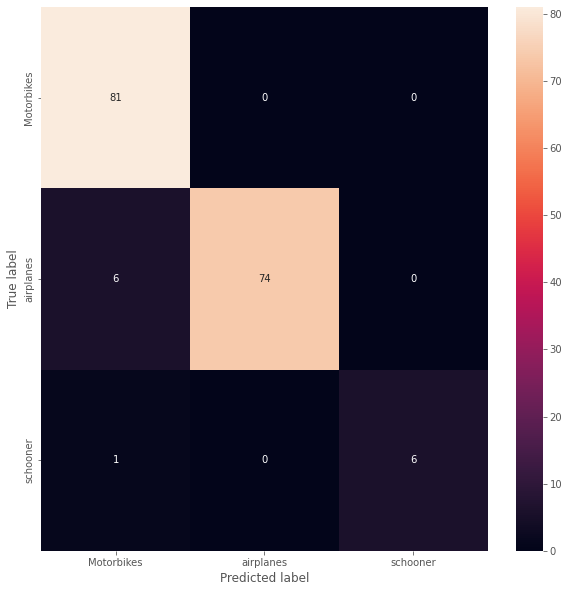

In [127]:
#print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pred=np.argmax(pred_labels,axis=1)
true=test_ds.labels
cm = confusion_matrix(true, pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, xticklabels=list(val_ds.class_indices.keys()), yticklabels=list(val_ds.class_indices.keys()))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(Path(base_path,"confusion_matrix.png"),dpi=300)

In [128]:
print(test_accuracies)
print(test_losses)
print(training_times)

{'Trail 1': 0.9940476417541504, 'Trail 2': 0.9940476417541504, 'Trail 3': 0.9940476417541504, 'Trail 4': 0.9583333134651184}
{'Trail 1': 0.07167135179042816, 'Trail 2': 0.09147582948207855, 'Trail 3': 0.10367380827665329, 'Trail 4': 0.1958087533712387}
{'Trail 1': datetime.timedelta(seconds=28, microseconds=1146), 'Trail 2': datetime.timedelta(seconds=29, microseconds=60119), 'Trail 3': datetime.timedelta(seconds=27, microseconds=951276), 'Trail 4': datetime.timedelta(seconds=94, microseconds=983467)}


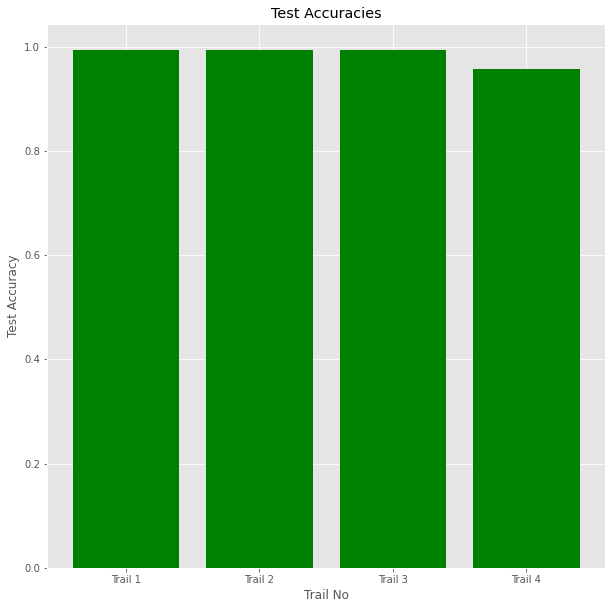

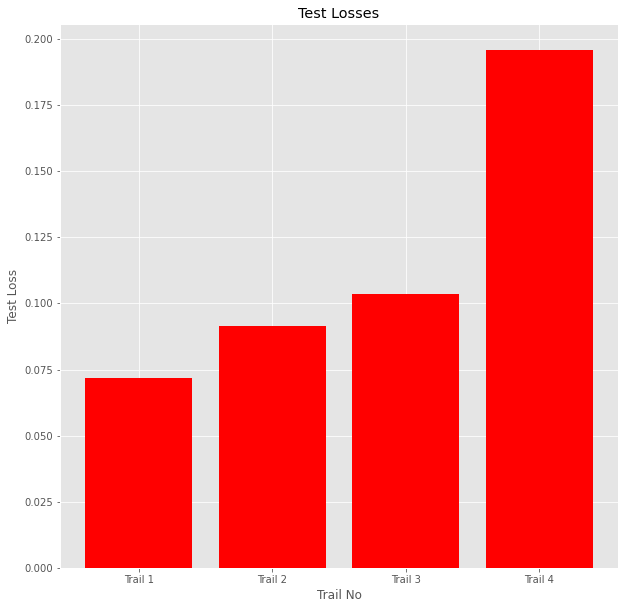

In [135]:
#bar chart for test accuracies
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,10))
plt.bar(test_accuracies.keys(),test_accuracies.values(),color='g')
plt.title("Test Accuracies")
plt.xlabel("Trail No")
plt.ylabel("Test Accuracy")
plt.savefig("test_accuracies.png",dpi=300)

#bar chart for test losses

plt.figure(figsize=(10,10))
plt.bar(test_losses.keys(),test_losses.values(),color='r')
plt.title("Test Losses")
plt.xlabel("Trail No")
plt.ylabel("Test Loss")
plt.savefig("test_losses.png",dpi=300)



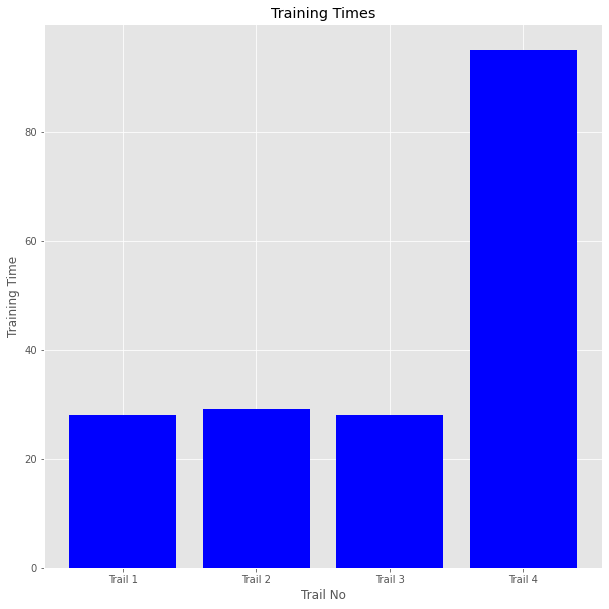

In [139]:
#convert datetime to seconds
import datetime
for key in training_times:
    training_times[key]=training_times[key].total_seconds()

#bar chart for training times

plt.figure(figsize=(10,10))
plt.bar(training_times.keys(),training_times.values(),color='b')
plt.title("Training Times")
plt.xlabel("Trail No")
plt.ylabel("Training Time")
plt.savefig("training_times.png",dpi=300)
